In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

u_star = np.array([
    [0, 0.5, 0, 0.5, 0],
    [0.5, 0, 0.5, 0, 0.5],
    [0, 0.5, 0, 0.5, 0],
    [0.5, 0, 0.5, 0, 0],
    [0, 0.5, 0, 0, 0]
])

y_init = np.array([1, -1, -1, 1, 1])
p = len(y_init)

def ising_gibbs_sampler(u, y_init, n_samples=1000, burn_in=5000):
    """
    Gibbs sampler for the Ising model
    
    Parameters:
    u: interaction matrix (p x p)
    y_init: initial state (p,)
    n_samples: number of samples to generate after burn-in
    burn_in: number of burn-in samples
    
    Returns:
    samples: array of shape (n_samples, p)
    """
    p = len(y_init)
    total_samples = n_samples + burn_in
    samples = np.zeros((total_samples, p))
    samples[0] = y_init.copy()
    
    for n in range(1, total_samples):
        # Start from previous sample
        y_current = samples[n-1].copy()
        
        # Update each variable in sequence
        for r in range(p):
            # Compute A = sum_{t != r} u_{r,t} y_t
            A = 0
            for t in range(p):
                if t != r:
                    A += u[r, t] * y_current[t]
            
            # Compute probability P(y_r = 1 | y_{V\r})
            p_plus = np.exp(2 * A) / (np.exp(2 * A) + 1)
            
            # Sample y_r
            if np.random.rand() < p_plus:
                y_current[r] = 1
            else:
                y_current[r] = -1
        
        samples[n] = y_current.copy()
    
    # Return samples after burn-in
    return samples[burn_in:]

In [2]:
samples = ising_gibbs_sampler(u_star, y_init)

sample_mean = np.mean(samples, axis=0)
sample_var = np.var(samples, axis=0)

print("\nSample Statistics:")
print(f"{'Variable':<10} {'Mean':<10} {'Variance':<10}")
for i in range(p):
    print(f"{i+1:<10} {sample_mean[i]:<10.3f} {sample_var[i]:<10.3f}")


Sample Statistics:
Variable   Mean       Variance  
1          -0.024     0.999     
2          0.016      1.000     
3          0.024      0.999     
4          0.026      0.999     
5          0.014      1.000     



Correlation Matrix:
[[1.         0.51259725 0.38479764 0.50293884 0.24643113]
 [0.51259725 1.         0.54784391 0.37375818 0.46988219]
 [0.38479764 0.54784391 1.         0.48968254 0.30978358]
 [0.50293884 0.37375818 0.48968254 1.         0.21172832]
 [0.24643113 0.46988219 0.30978358 0.21172832 1.        ]]


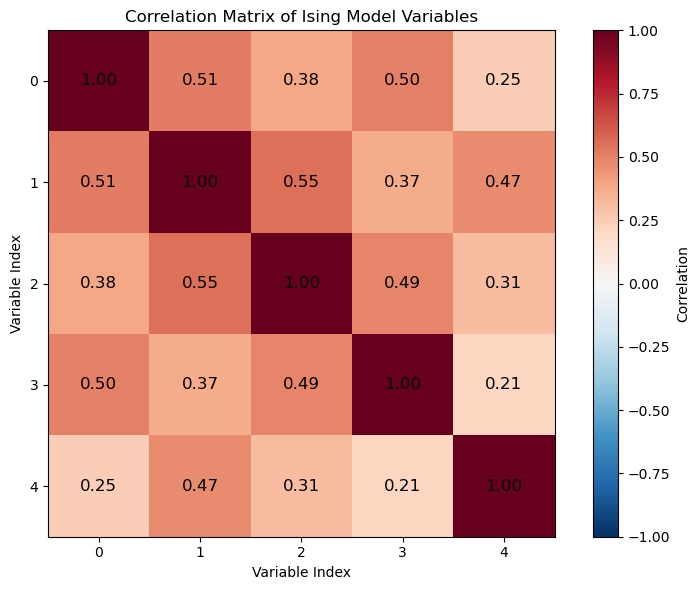

In [3]:
# corr
correlation_matrix = np.corrcoef(samples.T)

print("\nCorrelation Matrix:")
print(correlation_matrix)

# Plot correlation matrix
plt.figure(figsize=(8, 6))
im = plt.imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation')
plt.title('Correlation Matrix of Ising Model Variables')
plt.xlabel('Variable Index')
plt.ylabel('Variable Index')

# Add correlation values as text
for i in range(p):
    for j in range(p):
        plt.text(j, i, f'{correlation_matrix[i, j]:.2f}', 
                ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

In [4]:
from scipy.stats import laplace
import math

np.random.seed(100)

def metropolis_hastings(log_target, initial_state, proposal_std=0.1, n_samples=1000, burn_in=10000):

    n_params = len(initial_state)
    total_samples = n_samples + burn_in
    samples = np.zeros((total_samples, n_params))
    samples[0] = initial_state.copy()
    
    current_state = initial_state.copy()
    current_log_target = log_target(current_state)
    
    for n in range(1, total_samples):
        # Propose new state (Gaussian random walk)
        proposed_state = current_state + np.random.normal(0, proposal_std, n_params)
        
        # Compute log-target for proposed state
        proposed_log_target = log_target(proposed_state)
        
        # acceptance probability
        log_alpha = proposed_log_target - current_log_target
        alpha = min(1, np.exp(log_alpha))
        
        # accept/reject
        if np.random.rand() < alpha:
            current_state = proposed_state
            current_log_target = proposed_log_target
        
        samples[n] = current_state.copy()
    
    return samples[burn_in:]

def vectorize_u(u):
    """Convert symmetric matrix to vector of free parameters"""
    p = u.shape[0]
    u_vec = []
    for i in range(p):
        for j in range(i+1, p):
            u_vec.append(u[i, j])
    return np.array(u_vec)

def unvectorize_u(u_vec, p=5):
    """Convert vector back to symmetric matrix"""
    u_mat = np.zeros((p, p))
    idx = 0
    for i in range(p):
        for j in range(i+1, p):
            u_mat[i, j] = u_vec[idx]
            u_mat[j, i] = u_vec[idx]
            idx += 1
    return u_mat

def partition(u_mat):
    """Compute partition function Z(u) by brute force"""
    p = u_mat.shape[0]
    states = []
    
    # Generate all 2^p possible states
    for i in range(2**p):
        state = []
        for j in range(p):
            state.append(1 if (i >> j) & 1 else -1)
        states.append(state)
    
    states = np.array(states)
    
    # Compute Z(u) = sum_y exp(sum_{i<j} u_ij y_i y_j)
    Z = 0
    for state in states:
        energy = 0
        for i in range(p):
            for j in range(i+1, p):
                energy += u_mat[i, j] * state[i] * state[j]
        Z += np.exp(energy)
    
    return Z

def log_posterior(data, lamb=0.2):
    """Create log-posterior function for given data"""
    def log_posterior(u_vec):
        # Convert to matrix form
        u_mat = unvectorize_u(u_vec)
        
        # Compute log-likelihood
        log_lik = 0
        for sample in data:
            energy = 0
            for i in range(5):
                for j in range(i+1, 5):
                    energy += u_mat[i, j] * sample[i] * sample[j]
            log_lik += energy
        
        # Subtract log partition function
        Z = partition(u_mat)
        log_lik -= len(data) * np.log(Z)
        
        # Compute log-prior (Laplace prior)
        log_prior = np.sum(laplace.logpdf(u_vec, scale=1/lamb))
        
        return log_lik + log_prior
    
    return log_posterior

In [5]:
# log-posterior function
log_posterior_fn = log_posterior(samples)

# Initial state
initial_u_vec = np.zeros(int(p*(p-1)/2)) + 0.1  # free parameters

# MCMC
samples_u = metropolis_hastings(log_target=log_posterior_fn, initial_state=initial_u_vec)

In [6]:
# Analysis

true_u_vec = vectorize_u(u_star)
posterior_means = np.mean(samples_u, axis=0)
posterior_vars = np.var(samples_u, axis=0)

print("\nCOMPARISON: TRUE vs ESTIMATED")
param_labels = []
p = 5
for i in range(p):
    for j in range(i+1, p):
        param_labels.append(f"u_{i+1}{j+1}")

print(f"{'Parameter':<10} {'True':<10} {'Sample_Mean':<12} {'Error':<10} {'Sample_Variance':<10}")
for idx, label in enumerate(param_labels):
    true_val = true_u_vec[idx]
    est_mean = posterior_means[idx]
    est_var = posterior_vars[idx]
    error = abs(true_val - est_mean)
    print(f"{label:<10} {true_val:<10.3f} {est_mean:<11.3f}  {error:<10.3f} {est_var:<10.6f}")


COMPARISON: TRUE vs ESTIMATED
Parameter  True       Sample_Mean  Error      Sample_Variance
u_12       0.500      0.482        0.018      0.000297  
u_13       0.000      -0.007       0.007      0.000676  
u_14       0.500      0.500        0.000      0.002574  
u_15       0.000      -0.008       0.008      0.000360  
u_23       0.500      0.456        0.044      0.001551  
u_24       0.000      -0.037       0.037      0.000968  
u_25       0.500      0.442        0.058      0.000693  
u_34       0.500      0.497        0.003      0.000483  
u_35       0.000      0.163        0.163      0.000981  
u_45       0.000      -0.044       0.044      0.000747  


In [7]:
estimated_u_mat = unvectorize_u(posterior_means)

print("\nTRUE u*:")
print(np.round(u_star, 3))
print("\nESTIMATED u:")
print(np.round(estimated_u_mat, 3))


TRUE u*:
[[0.  0.5 0.  0.5 0. ]
 [0.5 0.  0.5 0.  0.5]
 [0.  0.5 0.  0.5 0. ]
 [0.5 0.  0.5 0.  0. ]
 [0.  0.5 0.  0.  0. ]]

ESTIMATED u:
[[ 0.     0.482 -0.007  0.5   -0.008]
 [ 0.482  0.     0.456 -0.037  0.442]
 [-0.007  0.456  0.     0.497  0.163]
 [ 0.5   -0.037  0.497  0.    -0.044]
 [-0.008  0.442  0.163 -0.044  0.   ]]


In [8]:
def compute_conditional_probability(y, u_mat, r):

    p = len(y)
    A_r = 0
    for t in range(p):
        if t != r:
            A_r += u_mat[r, t] * y[t]
    
    exp_2A = np.exp(2 * A_r)
    if y[r] == 1:
        p_r = exp_2A / (exp_2A + 1)
    else:  # y_r = -1
        p_r = 1 / (exp_2A + 1)
    
    return p_r, A_r

def compute_negative_log_likelihood(Y, u_mat):

    N, p = Y.shape
    neg_ll = 0.0
    
    for i in range(N):
        y = Y[i]
        for r in range(p):
            p_r, _ = compute_conditional_probability(y, u_mat, r)
            neg_ll -= np.log(p_r + 1e-15)  # Add small epsilon for stability
    
    return neg_ll

def compute_gradient(Y, u_mat):
    """
    Compute gradient of negative pseudo log-likelihood analytically
    Derived from the conditional probability formula
    """
    N, p = Y.shape
    grad = np.zeros((p, p))
    
    for i in range(N):
        y = Y[i]
        
        for r in range(p):

            A_r = 0
            for t in range(p):
                if t != r:
                    A_r += u_mat[r, t] * y[t]
            
            z = 2 * y[r] * A_r
            if z > 0:
                sigma = 1 / (1 + np.exp(-z))
            else:
                exp_z = np.exp(z)
                sigma = exp_z / (1 + exp_z)
            
            # Gradient contribution from this conditional
            for t in range(p):
                if t != r:
                    grad_rt = -2 * y[r] * y[t] * (1 - sigma)  # Negative gradient for negative log-likelihood
                    grad[r, t] += grad_rt
    
    # Average over samples and enforce symmetry
    grad = grad / N
    grad_sym = (grad + grad.T) / 2
    np.fill_diagonal(grad_sym, 0)
    
    return grad_sym

def soft_threshold(x, threshold):
    """Soft thresholding operator for L1 regularization"""
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def proximal_gradient_descent(Y, lambda_reg=10.0, step_size=0.001, 
                                      max_iter=1000, tol=1e-6):
    """
    Proximal Gradient Descent with corrected gradient computation
    
    Parameters:
    -----------
    lambda_reg: regularization parameter (should be larger for weaker regularization)
                The objective is: negative_log_likelihood + (1/lambda_reg) * ‖u‖₁
    """
    N, p = Y.shape
    
    # Initialize with small values
    np.random.seed(1)
    u_mat = np.random.randn(p, p) * 0.01
    u_mat = (u_mat + u_mat.T) / 2  # Make symmetric
    np.fill_diagonal(u_mat, 0)     # Zero diagonal
    
    losses = []
    
    for iteration in range(max_iter):
        u_prev = u_mat.copy()
        
        # Compute gradient
        grad = compute_gradient(Y, u_mat)
        
        # Gradient step
        u_gd = u_mat - step_size * grad
        
        # Proximal step (soft thresholding)
        # Threshold = step_size / lambda_reg
        threshold = step_size / lambda_reg
        
        u_new = np.zeros((p, p))
        for i in range(p):
            for j in range(i+1, p):
                u_ij = soft_threshold(u_gd[i, j], threshold)
                u_new[i, j] = u_ij
                u_new[j, i] = u_ij
        
        np.fill_diagonal(u_new, 0)
        u_mat = u_new
        
        # Compute loss
        neg_ll = compute_negative_log_likelihood(Y, u_mat)
        l1_penalty = np.sum(np.abs(u_mat)) / lambda_reg
        total_loss = neg_ll + l1_penalty
        losses.append(total_loss)
        
        # Check convergence
        u_change = np.linalg.norm(u_mat - u_prev, 'fro')
        
        if (iteration % 100 == 0 or iteration == max_iter - 1):
            print(f"Iter {iteration:4d}: Loss = {total_loss:.6f}, "
                  f"delta_u = {u_change:.6f}")
        
        if u_change < tol and iteration > 10:
            print(f"Converged at iteration {iteration}")
            break
    
    return u_mat, losses

In [23]:
u_final, losses_final = proximal_gradient_descent(
    samples,
    lambda_reg=50,
    step_size=0.01,
    max_iter=10000,
    tol=1e-4
)

print(f"\nTrue u*:")
print(np.round(u_star, 3))

print(f"\nEstimated u:")
print(np.round(u_final, 3))

print(f"\nParameter comparison:")
print(f"{'Param':<8} {'True':<8} {'Estimated':<12} {'Error':<10}")

for i in range(5):
    for j in range(i+1, 5):
        true_val = u_star[i, j]
        est_val = u_final[i, j]
        error = est_val - true_val
        
        param_name = f"u_{i+1}{j+1}"
        print(f"{param_name:<8} {true_val:<8.3f} {est_val:<12.3f} {error:<10.3f}")

Iter    0: Loss = 3461.548881, delta_u = 0.019115
Iter  100: Loss = 2566.766582, delta_u = 0.003819
Iter  200: Loss = 2482.772336, delta_u = 0.001846
Iter  300: Loss = 2456.665968, delta_u = 0.001166
Iter  400: Loss = 2445.270150, delta_u = 0.000801
Iter  500: Loss = 2439.558562, delta_u = 0.000572
Iter  600: Loss = 2436.394431, delta_u = 0.000406
Iter  700: Loss = 2434.632760, delta_u = 0.000298
Iter  800: Loss = 2433.550829, delta_u = 0.000181
Iter  900: Loss = 2432.938353, delta_u = 0.000121
Converged at iteration 950

True u*:
[[0.  0.5 0.  0.5 0. ]
 [0.5 0.  0.5 0.  0.5]
 [0.  0.5 0.  0.5 0. ]
 [0.5 0.  0.5 0.  0. ]
 [0.  0.5 0.  0.  0. ]]

Estimated u:
[[0.    0.437 0.008 0.429 0.   ]
 [0.437 0.    0.459 0.    0.43 ]
 [0.008 0.459 0.    0.407 0.076]
 [0.429 0.    0.407 0.    0.009]
 [0.    0.43  0.076 0.009 0.   ]]

Parameter comparison:
Param    True     Estimated    Error     
u_12     0.500    0.437        -0.063    
u_13     0.000    0.008        0.008     
u_14     0.500    

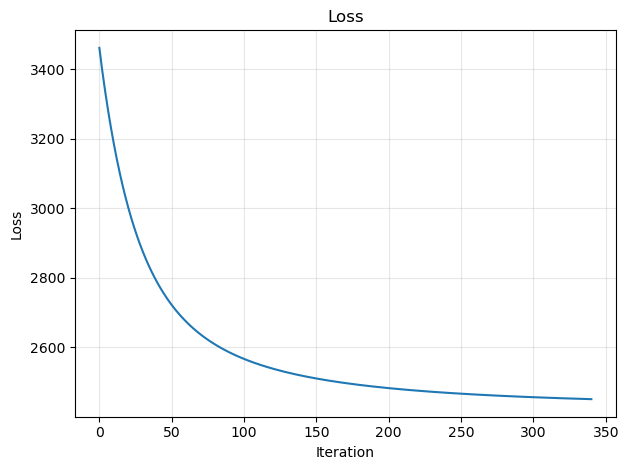

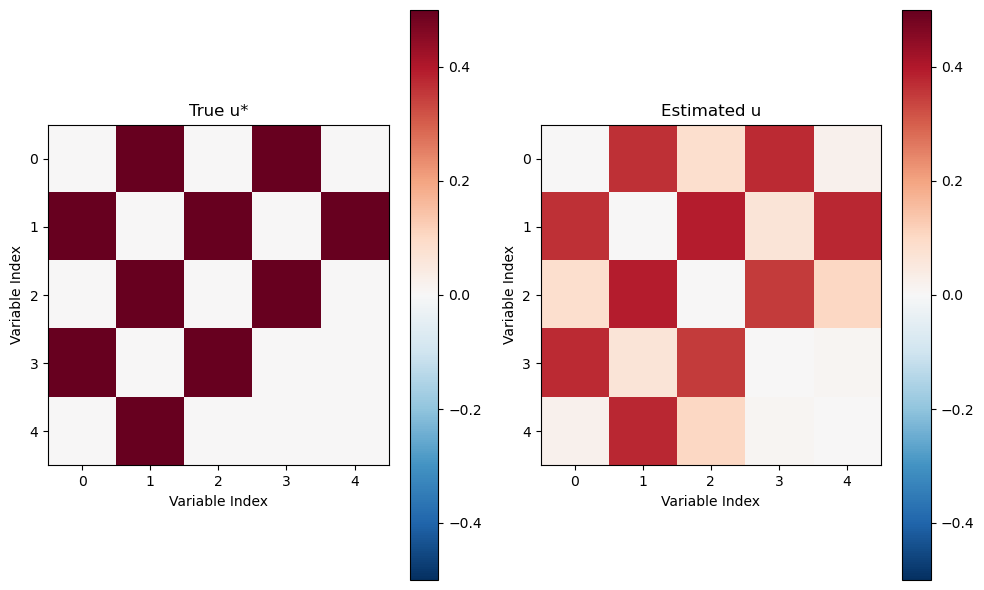

In [10]:
# Loss convergence
plt.plot(losses_final)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# True matrix
im1 = axes[0].imshow(u_star, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
axes[0].set_title('True u*')
axes[0].set_xlabel('Variable Index')
axes[0].set_ylabel('Variable Index')
fig.colorbar(im1, ax=axes[0])

# Estimated matrix
im2 = axes[1].imshow(u_final, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
axes[1].set_title(f'Estimated u')
axes[1].set_xlabel('Variable Index')
axes[1].set_ylabel('Variable Index')
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [65]:
import time

p_list = list(range(5, 16))

time_mh = []
time_pgd = []
error_mh = []
error_pgd = []

for p in p_list:
    
    np.random.seed(1)

    #Gibbs
    
    u_star = np.random.randn(p, p) * 0.5
    u_star = (u_star + u_star.T) / 2
    np.fill_diagonal(u_star, 0)
    u_star[np.abs(u_star) < 0.5] = 0
    u_star[u_star > 1] = 1
    u_star[u_star < -1] = -1

    y_init = 2*np.random.randint(0, 2, size=p) - 1 # Random list of 1s and -1s
    samples = ising_gibbs_sampler(u_star, y_init, n_samples=200*p, burn_in=1000*p)

    # MH
    
    start = time.perf_counter()
    
    # log-posterior function
    log_posterior_fn = log_posterior(samples)
    # Initial state
    initial_u_vec = np.zeros(int(p*(p-1)/2)) + 0.1
    # MCMC
    samples_u = metropolis_hastings(log_target=log_posterior_fn, initial_state=initial_u_vec, n_samples=int(100*p*(p-1)/2), burn_in=int(1000*p*(p-1)/2))

    posterior_means = np.mean(samples_u, axis=0)
    estimated_u_mat = unvectorize_u(posterior_means, p=p)
    
    end = time.perf_counter()

    time_mh.append(end-start)
    error_mh.append(np.linalg.norm(estimated_u_mat - u_star, 'fro'))

    #PGD

    start = time.perf_counter()
    
    u_final, losses_final = proximal_gradient_descent(
    samples,
    lambda_reg=50,
    step_size=0.01,
    max_iter=10000,
    tol=1e-5*p*(p-1)/2
    )

    end = time.perf_counter()

    time_pgd.append(end-start)
    error_pgd.append(np.linalg.norm(u_final - u_star, 'fro'))

Iter    0: Loss = 3380.646032, delta_u = 0.016616
Iter  100: Loss = 2531.947579, delta_u = 0.004337
Iter  200: Loss = 2422.238802, delta_u = 0.002143
Iter  300: Loss = 2387.914881, delta_u = 0.001301
Iter  400: Loss = 2373.029367, delta_u = 0.000907
Iter  500: Loss = 2365.369303, delta_u = 0.000667
Iter  600: Loss = 2361.061162, delta_u = 0.000503
Iter  700: Loss = 2358.495148, delta_u = 0.000386
Iter  800: Loss = 2356.899559, delta_u = 0.000299
Iter  900: Loss = 2355.872159, delta_u = 0.000234
Iter 1000: Loss = 2355.100317, delta_u = 0.000147
Iter 1100: Loss = 2354.583033, delta_u = 0.000104
Converged at iteration 1112
Iter    0: Loss = 4909.244964, delta_u = 0.014500
Iter  100: Loss = 3973.398088, delta_u = 0.004521
Iter  200: Loss = 3838.124983, delta_u = 0.002038
Iter  300: Loss = 3801.883762, delta_u = 0.001115
Iter  400: Loss = 3788.459586, delta_u = 0.000688
Iter  500: Loss = 3782.430543, delta_u = 0.000457
Iter  600: Loss = 3779.380822, delta_u = 0.000316
Iter  700: Loss = 3777

In [67]:
print(time_mh)
print(time_pgd)

[66.0243009000551, 117.71031860006042, 183.22357869998086, 280.7475531999953, 406.25772049999796, 553.3755428000586, 750.6182264999952, 1103.6205481999787, 1415.560240300023, 1594.2390487999655, 1937.7661476000212]
[69.05384810001124, 79.94849740003701, 66.9174535999773, 166.83841730002314, 233.58385469997302, 172.179762499989, 237.05158990004566, 590.3896399999503, 550.6005001999438, 566.7269323000219, 831.2564294000622]


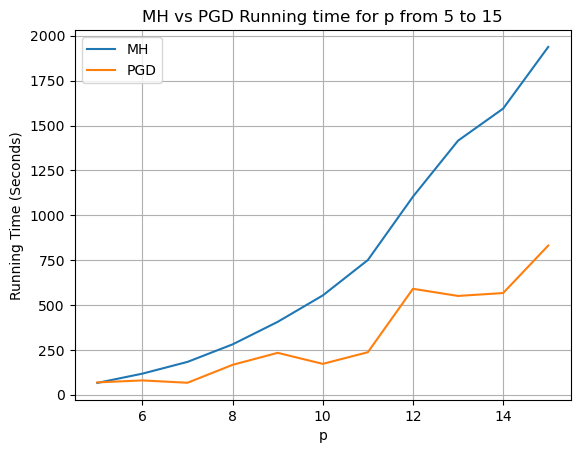

In [77]:
plt.figure()
plt.plot(p_list, time_mh, label='MH')
plt.plot(p_list, time_pgd, label='PGD')
plt.xlabel("p")
plt.ylabel("Running Time (Seconds)")
plt.title("MH vs PGD Running time for p from 5 to 15")
plt.grid(True)
plt.legend()
plt.show()

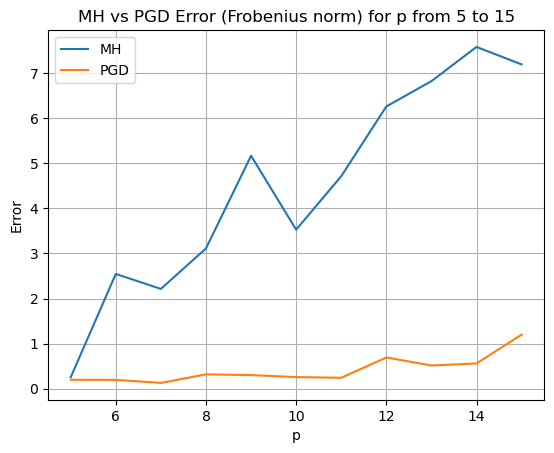

In [81]:
plt.figure()
plt.plot(p_list, error_mh, label='MH')
plt.plot(p_list, error_pgd, label='PGD')
plt.xlabel("p")
plt.ylabel("Error")
plt.title("MH vs PGD Error (Frobenius norm) for p from 5 to 15")
plt.grid(True)
plt.legend()
plt.show()

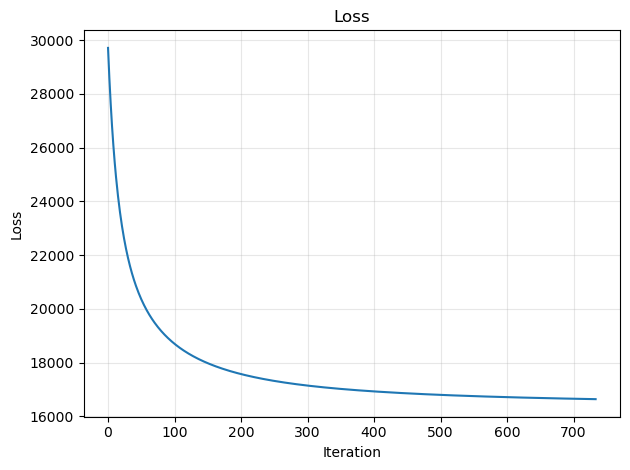

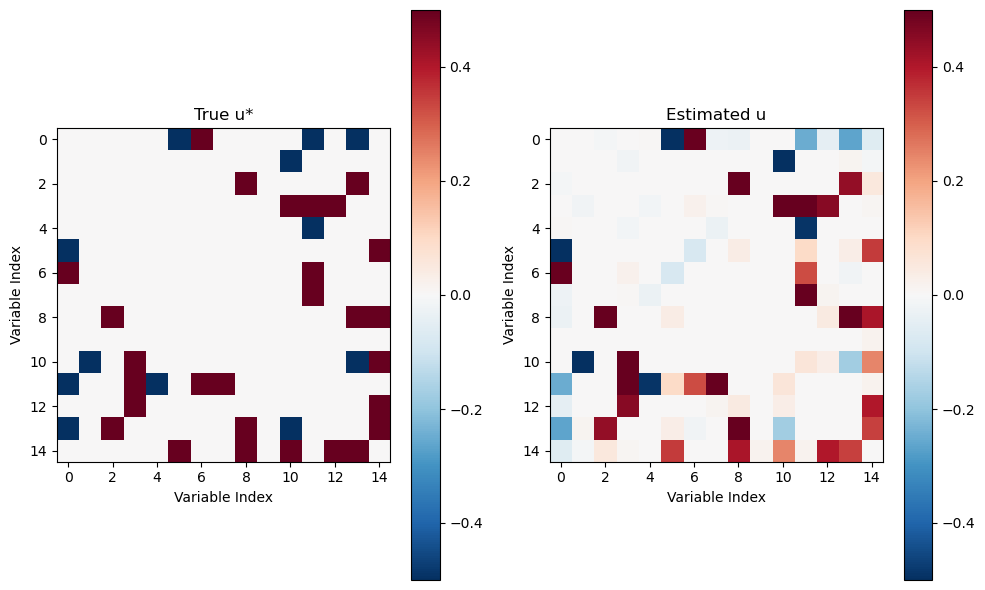

In [95]:
# Loss convergence
plt.plot(losses_final)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# True matrix
im1 = axes[0].imshow(u_star, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
axes[0].set_title('True u*')
axes[0].set_xlabel('Variable Index')
axes[0].set_ylabel('Variable Index')
fig.colorbar(im1, ax=axes[0])

# Estimated matrix
im2 = axes[1].imshow(u_final, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
axes[1].set_title(f'Estimated u')
axes[1].set_xlabel('Variable Index')
axes[1].set_ylabel('Variable Index')
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

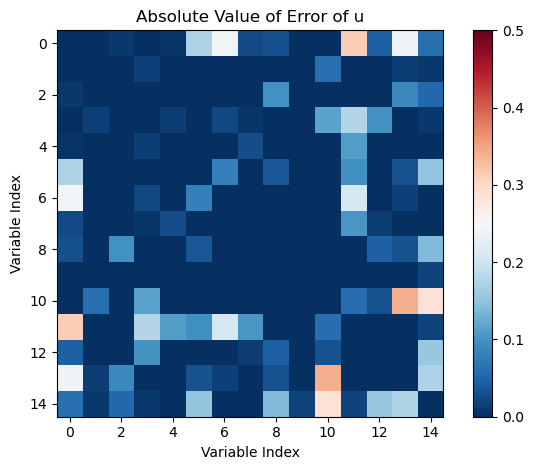

In [107]:
# Error matrix
im = plt.imshow(abs(u_final-u_star), cmap='RdBu_r', vmin=0, vmax=0.5)
plt.title(f'Absolute Value of Error of u')
plt.xlabel('Variable Index')
plt.ylabel('Variable Index')
plt.colorbar(im)

plt.tight_layout()
plt.show()